In [42]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
# from functools import partial
from multiprocessing import Pool
from functools import partial
from sklearn import metrics
import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import clear_output
import datetime
import itertools
# from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib as mpl
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import matplotlib.patheffects as pe
%matplotlib notebook

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
import MiscFuncs as MF
importlib.reload(Dense)
importlib.reload(RSTF)
importlib.reload(MF)

# %matplotlib inline
%config IPCompleter.greedy=True

import scipy
from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
# from sklearn.externals 
import joblib
from matplotlib import cm

import matplotlib as mpl
mpl.rcParams["mathtext.default"] = 'regular'

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

from ipywidgets import FloatProgress
from IPython.display import display
import os  
import shutil
from keras import backend as K
try:pool.close()
except:pass

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from ipywidgets import FloatProgress, HTML

def t(p,n):
    alpha = 1-p
    df = n-1
    return(stats.t.ppf(alpha,df))

pd.set_option('max_colwidth',200)
MP=True

cwd = os.getcwd()
def Performance(ax,title,target,verbose,lim=None):
    ax.bar(target.level_best['Size'].values,target.level_best['MSE'].values,
            yerr=target.level_best['SE'].values*target.Rule,color='grey',
            alpha = .8,label='Best model at\neach size')
    ax.bar(target.Best['Size'].values,target.Best['MSE'].values,
           yerr=target.Best['SE'].values*target.Rule,
           color='red',alpha = 1,label='Parsimony')
    yaxy = ax.twiny()
    yaxy.bar(target.level_best['Size'].values,target.level_best['MSE'].values,
             yerr=target.level_best['SE'].values*target.Rule,
             color='grey',
             alpha = 0,label=None)
    yaxy.set_xlabel('Number of Factors')
    ax.set_xlabel('Additional Model Input')
    ax.set_title(title,y=1.1,loc='left')
    ax.plot([target.level_best['Size'].min(),target.level_best['Size'].max()],
            [target.Min['MSE'].values[0]+target.Min['SE'].values[0]*target.Rule,
            target.Min['MSE'].values[0]+target.Min['SE'].values[0]*target.Rule])
    plt.sca(ax)
    plt.grid()
    if lim is not None:
        ax.set_xlim(lim)
        yaxy.set_xlim(lim)
    
    i=1
    Labs = []
    for mod in target.level_best.Model.unique():
        print(i,mod)
        if i >1:
            Labs.append([val for val in mod.split('+') if val not in modold.split('+')][0])
        else:
            Labs.append(mod)
        modold=mod
        i+=1
    labels = []
    for lab in Labs:
        labels.append(aliases[lab])
    plt.xticks(target.level_best['Size'],labels,rotation=90)
    if verbose>1:
        print(target.Best)
    
def LevelPerformance(ax,title,target,level=1,Rule=1):
    Data = target.Records.loc[target.Records['Size']==level].sort_values('MSE').reset_index()
    
    if level == 1:
        Data['Name']=Data['Model']
        for val in Data['Model']:
            Data.loc[Data['Model']==val,'Name']=aliases[val]
        Min = Data[Data['MSE']==Data['MSE'].min()]
        Myax = Min['MSE'].values[0]+Min['SE'].values[0]*Rule
        Best = Data[Data['MSE']<=Myax]
        ax.bar(Data['Name'],Data['MSE'].values,
               yerr=Data['SE'].values*target.Rule,
               color='grey',
            alpha = .8,label='Best model at\neach size')
        ax.bar(Best['Name'],Best['MSE'].values,
               yerr=Best['SE'].values*target.Rule,
               color='red',
               alpha = 1,
               label='Parsimony')
        ax.bar(Min['Name'],Min['MSE'].values,
               yerr=Min['SE'].values*target.Rule,
               color='blue',
               alpha = 1,
               label='Parsimony')
    else:
#         alpha = .025
        Min = Data[Data['MSE']==Data['MSE'].min()]
        Myax = Min['MSE'].values[0]+Min['SE'].values[0]*Rule
        Best = Data[Data['MSE']<= Myax]
        ax.bar(Data.index,Data['MSE'].values,
               yerr=Data['SE'].values*target.Rule,
               color='grey',
            alpha = .8,label='Best model at\neach size')
        ax.bar(Best.index,Best['MSE'].values,
               yerr=Best['SE'].values*target.Rule,
               color='red',alpha = 1,label='Parsimony')
        ax.bar(Min.index,Min['MSE'].values,
               yerr=Min['SE'].values*target.Rule,
               color='blue',alpha = 1,label='Parsimony')
    ax.plot([Data.index[0],Data.index[-1]],[Myax,Myax])
    ax.grid()
    print(Data)

def Mapper(AllData,target,name,Fill=False,DarkTarget=None):
    target.Project(Projector = None,
                Model = None)
    if DarkTarget is None:
        target.RST.Data = AllData
    else:
        target.RST.Data = DarkTarget
    print(target.params['target'],target.params['Inputs'],
                       target.params['Spath'])
    if DarkTarget is None:
        target.RST.Scale(target.params['target'],target.params['Inputs'],
                       ScalePath=target.params['Spath'],Project=True)
    else:
        target.RST.Data = DarkTarget
        target.RST.Scale(target.params['target'],target.params['Inputs'],
                   ScalePath=target.params['Spath'],Project=True,fillTarget = DarkTarget)
    target.Map(Fill)
    AllData[name] = target.Data_Map[target.target].values
#     print(AllData[name])
    AllData[name+'_Var_reg'] = target.Data_Map['Var_reg'].values
    AllData[name+'_Var_er'] = target.Data_Map['Var_er'].values
    AllData[name+'_CI'] = target.Data_Map['CI'].values
    AllData[name+'_PI'] = target.Data_Map['PI'].values
    return(AllData)

def PooledVar_interval(Data,Vars,mean,n): 
    Ux = 1/(Data[Vars].count(axis=0).sum())*(Data[Vars].count(axis=0)*Data[Vars].mean(axis=0)).sum()
    P1 = ((Data[Vars].count(axis=0)-1)*Data[Vars].std(axis=0)**2+Data[Vars].count(axis=0)*Data[Vars].mean(axis=0)**2).sum()
    P2 = Data[Vars].count(axis=0).sum()*Ux**2
    VarX = 1/(Data[Vars].count(axis=0)-1).sum()*(P1-P2)
    SigmaX = (VarX)**.5
    return(SigmaX)

class ResultMap:
    def __init__(self,Path,target,Test='N/A',Rule=1,alpha = .025,DataName ='AllData.csv', AltPath=None,Site='FishIsland',FPVars=None):
        self.FPVars = FPVars
        self.target = target        
        self.params = Dense.Params(Path,'Full',self.target,MP)
        self.params['Dpath'] = cwd+'/'+Site+'/'
        self.RST = RSTF.ReadStandardTimeFill(self.params,DataName,FPVars = FPVars)
        if AltPath is None:
            self.Records = pd.read_csv(self.params['Dpath']+'/'+target+'_Runs.csv',delimiter = ',',header = 0,index_col=[0])
            self.params['Dpath'] += target+'/'
        else:
            self.Records = pd.read_csv(self.params['Dpath']+'/'+AltPath+'_Runs.csv',delimiter = ',',header = 0,index_col=[0])
            self.params['Dpath'] += AltPath+'/'           
        self.Records['Model_Key']=self.Records['Size'].astype(str)+'_'+self.Records['Nodes'].astype(str)
        self.Records['RMSE']=self.Records['MSE']**.5
        self.Min = self.Records.loc[self.Records['MSE']==self.Records['MSE'].min()]
        self.Best = self.Records.loc[self.Records.index==Rule]
        self.Model_Selection = self.Best['Model'].values[0]
                
    def Project(self,Projector = None,Model = None):
        if Model ==  None:
            self.Model = self.Model_Selection
        else:
            self.Model = Model
        idx = self.Records['Model_Key'].loc[self.Records['Model']==self.Model].values[0]
        self.params['Spath']=(self.params['Dpath']+idx+'/')
        self.params['Inputs'] = self.Model.split('+')
        self.RST.Scale(self.params['target'],self.params['Inputs'],ScalePath=self.params['Spath'])
        if Projector != None:
            if Projector['Map'] == None:
                for ip,val in zip(Projector['Assign']['input'],Projector['Assign']['value']):                    
                    self.RST.Data[ip] = val
            else:
                for ip in self.params['Inputs']:
                    self.RST.Data[ip] = self.RST.Data[ip].mean()
                for ip,val in zip(Projector['Map']['input'],Projector['Map']['min'],Projector['Map']['max']):                    
                    self.RST.Data[ip] = val
                
            self.RST.Scale(self.params['target'],self.params['Inputs'],ScalePath=self.params['Spath'],Project=True)
            
    def Map(self,Fill=False,Map=True):
        if Fill == True:
            X = self.RST.X_fill
        else:
            X = self.RST.X
        self.params['Sname']='Y_'
        Y_fill = []
        MSE = []
        prog1 = FloatProgress(min=0, max=self.params['K'],description='Running:')
        display(prog1)
        self.Weights=[]
        if __name__ == "__main__":
            pool = Pool(processes=3,maxtasksperchild=75)
            for k,results in enumerate(pool.imap(partial(Dense.Load_Model,X=X,params=self.params),
                                                 range(self.Best['K'].values[0]))):
                prog1.value+=1
                Y = results[0]
                self.Weights.append(results[1])
#                 print(Y)
                Yold = Y+0
                Y = self.RST.YScaled.inverse_transform(Y)
                if Fill == False and Map == False:
                    mse = (metrics.mean_squared_error(self.RST.y,Y))
                    MSE.append(mse)
                Y_fill.append(Y)
            pool.close()
        Y_fill = np.asanyarray(Y_fill).mean(axis=-1)
        Y_fill_bar = Y_fill.mean(axis=0)
        YTru = self.RST.y+0.0
        if Fill == False and Map == False:
            self.MSE = np.asanyarray(MSE)
            self.CI = stats.t.ppf(1-0.025,k)*self.MSE.std()/(k)**.5
        YStandard = joblib.load(self.params['Spath']+"YVar_scaler.save") 
        self.params['Sname']='Var'
        self.params['Loss']='Boot_Loss'
        
#         pool = Pool(processes=1,maxtasksperchild=75) 
#         for k,results in enumerate(pool.imap(partial(Dense.Load_Model,X=X,params=self.params),range(0,1))):

        for k in range(0,1):
            results=Dense.Load_Model(k,X=X,params=self.params)
            YVar = results[0]
#             self.Model=results[1]
#             YVar = self.RST.YvarScaled.inverse_transform(YVar)    
            YVar = YStandard.inverse_transform(YVar)                    
#         pool.close()
        X_back = np.squeeze(self.RST.XScaled.inverse_transform(X))
        self.Data_Map = pd.DataFrame(data=X_back,columns=self.params['Inputs'])
        try:
            self.Data_Map['key'] = self.RST.Data['key'].values
        except:
            pass
        self.Data_Map[self.target] = np.squeeze(Y_fill_bar)
        if Map == False:
            self.Data_Map['True'] = YTru
        self.Data_Map['Var_reg'] = 1/(self.params['K']-1)*((Y_fill-Y_fill_bar)**2).sum(axis=0)
        self.Data_Map['Var_er'] = np.squeeze(YVar)
        self.Data_Map['SE'] = self.Data_Map['Var_reg']**.5
        self.T = stats.t.ppf(1-0.025,self.params['K'])
        self.Data_Map['CI']=self.T*self.Data_Map['SE']
        self.Data_Map['PI']=self.T*((self.Data_Map['Var_er']+self.Data_Map['Var_reg'])**.5)
        self.Y_fill = Y_fill
        self.Y_fill_bar = Y_fill_bar
     
    # print(fch4.RST.X_fill.shape)


SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def RecRead(Path):
    AllRes={}
    for f in ['fco2','fch4']:#,'ER']:
        try:
            AllRes[f]={}
            AllRes[f]['Records']=pd.read_csv(Path+f+'_Runs.csv',index_col=0)
            AllRes[f]['Results']=pd.read_csv(Path+f+'_Results.csv',index_col=0)
        #         temp=open(Path+f+'_Removed.txt', "r")
        #         AllRes[f]['Removed'] = temp.read().split(',')
            AllRes[f]['Derivatives']={}
            AllRes[f]['SSQ'] ={}
            AllRes[f]['X'] = {}
            AllRes[f]['Yhat'] = {}
            AllRes[f]['Ytrue'] = {}
            AllRes[f]['Outputs'] = {}
        except:
            pass
    return(AllRes)

def DerivKeys(Resluts,col): 
    i =0
    Keys = {}
    for f,r in zip(Results.Factors.values,Results[col].values):
        if r > 0:
            Keys[f]=i
            i += 1
    return(Keys)

Variables=['H','LE','fco2','fch4',
           'wind_speed','air_pressure','AirTC_Avg','NR_Wm2_Avg',
           'PPFD_Avg',
           'Table_1','Temp_2_5_1','Temp_2_5_2','Temp_5_1',
           'Temp_5_2','Temp_15_1','Temp_15_2','Ts All Cent',
           'Ts All Rim','VWC_2','VWC_1','Active_Layer_1','24H Rain',
           'wind_dir','ER','Time','DOY',
           'VPD','u*','Wind_Direction','Delta_Table_1',
           'Rolling_Temp_15_1','Delta_air_pressure','Anoxic_Depth','Ratio',
           'Active_Layer_2','Rolling_NR_Wm2_Avg',
           'Rim','Collapse','Polygon','Daytime','nan','AirTemp_Avg','Net_SW_Wm2_Avg','Net_LW_Wm2_Avg','WindSpd',
           'DSSM','NDVI','Angle','SoilMoist(4)']
Aliases=['H','LE','F_{CO2}','F_{CH4}',
         'U','Pa','T$_{a}$','Rn',
         'PPFD',
         'W$_{TD}$','T$_{Poly 2.5}$','T$_{Rim 2.5}$','T$_{Ply 5}$',
         'T$_{Rim 5}$','T$_{Ply 15}$','T$_{Rim 15}$','Ts All Cent',
         'Ts All Rim','VWC$_{Rim}$','VWC$_{Ply}$','AL','24H Rain','Dir','ER','Time','DOY','VPD','u$^*$','Wind Dir','DW$_{TD}$',
         'Mean T$_{s 15 cm Poly}$','Dpa','Anoxic Depth','Ratio','Active_Layer_2','Mean Rn',
         'F$_{Rim}$','F$_{Tro}$','F$_{Ply}$','Daytime','nan','AirTemp_Avg',
         'Net_SW_Wm2_Avg','Net_LW_Wm2_Avg','WindSpd',
         'DSSM','NDVI','Angle','VWC']

Full_Input = {'AirTemp_Avg':'Ta',
              'Net_SW_Wm2_Avg':'Radiation', 
              'Net_LW_Wm2_Avg':'Radiation',
              'Angle':'SunPosition',
              'DSSM':'Seasonal',
              'NDVI_MODIS':'NDVI',
              'WindSpd':'U'}

NameDict = {}
for k,n in zip(Variables,Aliases):
    NameDict[k]=n
    
    

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Path = 'C:\\Users\\wesle\\NetworkAnalysis\\'
Site = 'FishIsland_2012/'
# Site = 'FishIsland_JustMet_Soil/'
Path = Path+Site
AllRes = RecRead(Path = Path) 

In [43]:


# fig,ax = plt.subplots(1,2,figsize=(5,5))
# fyg,ax2 = plt.subplots(1,figsize=(3.5,4))

for i,F in enumerate(['fco2','fch4']):
    Results = AllRes[F]['Results']
    Labels = ((Results.set_index('Factors')*-1)**.5+1).fillna(0).sum(axis=1).sort_values(ascending=False).index.values
    Records = AllRes[F]['Records']
#     print(Records['Remove'])
    MBE = []
    MBEs = []
    RMSE = []
    RMSEs = []
    r2 = []
    SDev = []

    for I in Records.index:
    #     print(I)
        
        y = np.load(Path+F+'_Yhat_'+I+'.npy')#.mean(axis=0)
        x = np.load(Path+F+'_Ytrue_'+I+'.npy')#.mean(axis=0)
        K = y.shape[0]
        df = pd.DataFrame(data={'target':y.flatten(),'y':x.flatten()}).dropna()

        mbe = (np.nansum((x-y),axis=1)/((x-y).shape[1]-np.isnan((x-y)).sum(axis=1)))
        MBEs.append(mbe.std())

        rmse = (np.nansum((x-y)**2,axis=1)/((x-y).shape[1]-np.isnan((x-y)).sum(axis=1)))**.5
        RMSEs.append(rmse.std())

        MBE.append((df['y']-df['target']).sum()/df['y'].count())
        SDev.append(np.abs(df['y']-df['target']).sum()/df['y'].count()*2**.5)
        RMSE.append(metrics.mean_squared_error(df['y'],df['target'])**.5)
        r2.append(metrics.r2_score(df['y'],df['target']))

    RMSEs=np.array(RMSEs)
    MBEs=np.array(MBEs)

    df = pd.DataFrame(index = Records.index,data = {'RMSE':RMSE,'SE':RMSEs/(K**.5),'MBE':MBE,'MBESE':MBEs/(K**.5),'R2':r2})
    df['Diff']=df['RMSE'].diff()
    Xlbls = []
    for v in Records.Remove:
        try:
            Xlbls.append(NameDict[v])
        except:
            Xlbls.append('N/A')
            pass
    df = df.iloc[::-1]
    df['Factor']=Xlbls[::-1]
    
    Mn = (df.loc[df['RMSE']==df['RMSE'].min()])
    Mn = (df.loc[df['R2']==df['R2'].max()])
    df['PCT'] = Mn['RMSE'].values[0]/df['RMSE']
    
#     print(Mn[['Factor','R2','RMSE','Diff','MBE']].round(3))
    print(df[['Factor','R2','RMSE','Diff','MBE','PCT']].round(3)[::-1])
    

     Factor     R2  RMSE  Diff  MBE  PCT
8_75    N/A  0.942  0.36   NaN  0.0  1.0
     Factor     R2   RMSE  Diff    MBE  PCT
8_43    N/A  0.697  6.924   NaN  0.077  1.0


                                                                                 Model  \
8_43  AirTemp_Avg+Net_SW_Wm2_Avg+Net_LW_Wm2_Avg+SoilMoist(4)+Daytime+DSSM+NDVI+WindSpd   

      Size  Nodes        MSE      RMSE        SE        r2  Performance   K  \
8_43     8     43  45.826482  6.769526  0.668901  0.715816            0  30   

         Thresh  Remove  
8_43  46.495382     NaN  
                                                                                 Model  \
8_43  AirTemp_Avg+Net_SW_Wm2_Avg+Net_LW_Wm2_Avg+SoilMoist(4)+Daytime+DSSM+NDVI+WindSpd   

      Size  Nodes        MSE      RMSE        SE        r2  Performance   K  \
8_43     8     43  45.826482  6.769526  0.668901  0.715816            0  30   

         Thresh  Remove  
8_43  46.495382     NaN  
          Factors  RC_Sum: 8_43  Cumsum
0     AirTemp_Avg         0.012   1.000
1         Daytime         0.033   0.988
2         WindSpd         0.033   0.956
3            NDVI         0.037   0.923
4  Net_LW_Wm2_Av

<IPython.core.display.Javascript object>


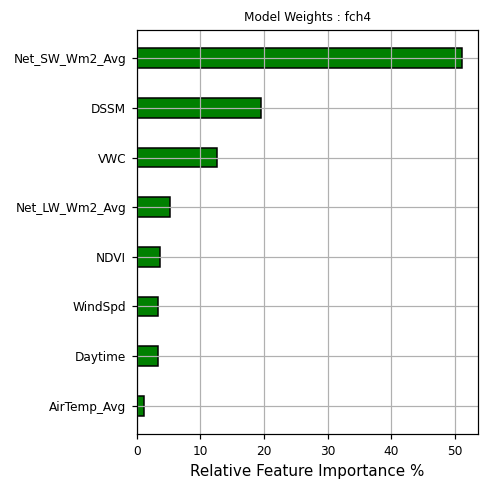

<IPython.core.display.Javascript object>


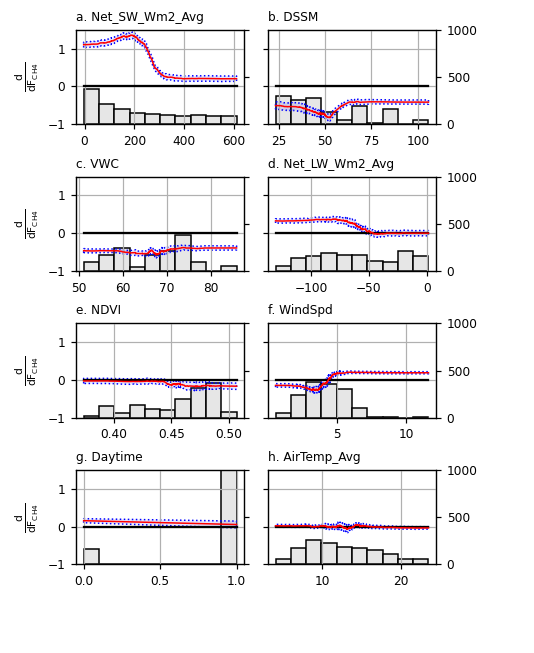

(1441, 2)
(1441, 2)
(1441, 2)
(1441, 2)
(1441, 2)
(1441, 2)
(1441, 2)
(1441, 2)
                                                                                 Model  \
8_75  AirTemp_Avg+Net_SW_Wm2_Avg+Net_LW_Wm2_Avg+SoilMoist(4)+Daytime+DSSM+NDVI+WindSpd   

      Size  Nodes       MSE      RMSE        SE        r2  Performance   K  \
8_75     8     75  0.117345  0.342557  0.001761  0.947325            0  30   

        Thresh  Remove  
8_75  0.119106     NaN  
                                                                                 Model  \
8_75  AirTemp_Avg+Net_SW_Wm2_Avg+Net_LW_Wm2_Avg+SoilMoist(4)+Daytime+DSSM+NDVI+WindSpd   

      Size  Nodes       MSE      RMSE        SE        r2  Performance   K  \
8_75     8     75  0.117345  0.342557  0.001761  0.947325            0  30   

        Thresh  Remove  
8_75  0.119106     NaN  
          Factors  RC_Sum: 8_75  Cumsum
0         WindSpd         0.006   1.000
1     AirTemp_Avg         0.021   0.994
2            NDVI       

<IPython.core.display.Javascript object>


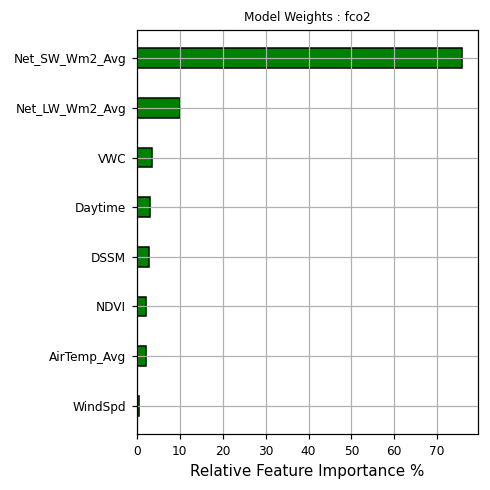

<IPython.core.display.Javascript object>


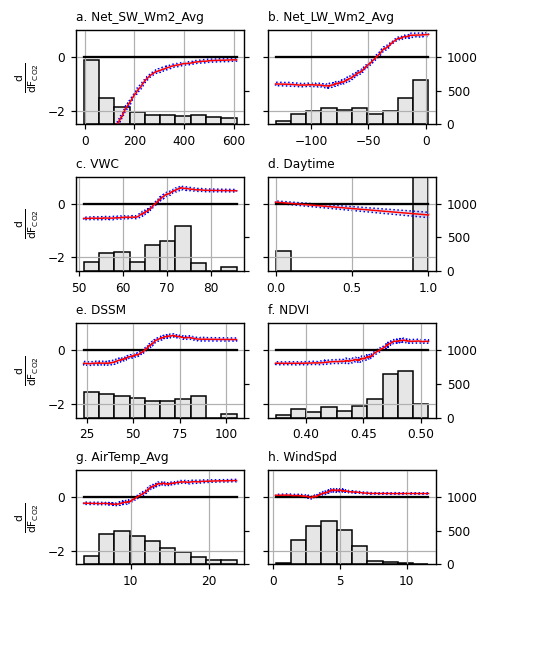

(2501, 2)
(2501, 2)
(2501, 2)
(2501, 2)
(2501, 2)
(2501, 2)
(2501, 2)
(2501, 2)


In [44]:
co2_Model_Index = '8_75'
ch4_Model_Index = '8_43'
if Site == 'FishIsland_JustMet_Soil/':
    co2_Model_Index = '5_75'
    ch4_Model_Index = '5_43'


for i,F in enumerate(['fch4','fco2']):
    RSM = 0
    Results = AllRes[F]['Results']
    Labels = ((Results.set_index('Factors')*-1)**.5+1).fillna(0).sum(axis=1).sort_values(ascending=False).index.values
    Records = AllRes[F]['Records']
    print(Records)
    
    Model_Index = co2_Model_Index
    if F == 'fch4':
        Model_Index = ch4_Model_Index
    elif F == 'ER':
        Model_Index = ER_Model_Index
    if Model_Index == None:
        Best = Records.loc[Records['Size']==Records['Size'].min()]
    else:
        Best = Records.loc[Records.index==Model_Index]    
    print(Best)
    Size = Best.Size.values[0]
    Nodes = Best.Nodes.values[0]
    # N = Records.Size.max()
    Records['RMSE']=Records['MSE']**.5
    Records['RSE']=Records['SE']**.5
    Best_U = 'RC_Sum: '+Best.index.values[0]
    
    Derivatives = np.load(Path+F+'_Derivatives_'+Best.index.values[0]+'.npy')
    Mean = Derivatives.mean(axis=0)
    Std = Derivatives.std(axis=0)
    X = np.load(Path+F+'_X_'+str(Size)+'.npy')

    Deriv_Labels= DerivKeys(Results,Best_U)
    SubSet = Results.loc[Results[Best_U]>0].sort_values(Best_U,ascending=True).reset_index()

    SubSet['Cumsum']=SubSet[Best_U].sort_values(ascending=False).cumsum().sort_values(ascending=False)
    print(SubSet[['Factors',Best_U,'Cumsum']].round(3))
    print(SubSet['Factors'].values)
    
    fig,ax=plt.subplots(figsize=(4.5,4.5))
    ax.barh(SubSet.index,SubSet[Best_U]*100,#xerr=SubSet[Best_SE]*100,
             height=.4,color='g',edgecolor='k')
    ax.set_yticks(SubSet.index)
    ax.set_yticklabels([NameDict[v] for v in SubSet['Factors'].values])

    ax.set_xlabel('Relative Feature Importance %')
    ax.set_title('Model Weights : '+F)
    ax.grid()
    plt.tight_layout()
    plt.savefig('PAD_'+F+'_PrunedFactors.png')
    
    Vars = SubSet.sort_values(by='Cumsum')['Factors'].values[:]
    C = 2
    Ysize = 5.5
    Xsize = 4.5
    
    import math
    from string import ascii_lowercase
    df = pd.DataFrame(data={'Vars':Vars})
    rsmp = 50
    R=math.ceil(len(Vars)/C)
    
    fig = plt.figure(figsize=(Xsize,Ysize))
    gs = fig.add_gridspec(R,C)
    r,c=0,0
    for j,Var in enumerate(Vars):
        if c == C:
            c = 0
            r+=1
        i=Deriv_Labels[Var]
        if c == 0:
            ax1 = fig.add_subplot(gs[r, c])#,sharex=ax2)
            ax1.set_ylabel(r'$\frac{d}{d'+NameDict[F]+'}$')
            ax2 = ax1.twinx()
            plt.setp(ax2.get_yticklabels(), visible=False)
        elif c == C-1:
            ax1 = fig.add_subplot(gs[r, c],sharey=ax1)#,sharex=ax2)
            ax2 = ax1.twinx()
            plt.setp(ax1.get_yticklabels(), visible=False)
        else:
            ax1 = fig.add_subplot(gs[r, c],sharey=ax1)#,sharex=ax2)
            ax2 = ax1.twinx()
            plt.setp(ax1.get_yticklabels(), visible=False)
            plt.setp(ax2.get_yticklabels(), visible=False)
        p = Derivatives.shape[0]
        ax1.plot([X[:,i].min(),X[:,i].max()],[0,0],color='k')
        
        
        Temp = pd.DataFrame(data={'X':X[:,i],'Y':(Mean[i].flatten())})#-m)*X[:,i].std()-X[:,i].mean()})
        Temp=Temp.sort_values(by='X')
#         print(Temp.shape)
        ax1.plot(Temp['X'],Temp['Y'],color='r',linewidth=1)
        ax2.hist(Temp['X'],facecolor=[.9,.9,.9],edgecolor='k')
        
        
        Temp1 = pd.DataFrame(data={'X':X[:,i],'Y':(Std[i]/(p**.5)*stats.t.ppf(.025,p))})#-m)*X[:,i].std()-X[:,i].mean()
        Temp1=Temp1.sort_values(by='X')

        ax1.fill_between(Temp['X'],
            (Temp['Y']-Temp1['Y']), 
            (Temp['Y']+Temp1['Y']),
            facecolor = [0,0,1,.1],
            edgecolor = 'b',
            linestyle=':',
            linewidth=1,
           )
        
        ax1.set_zorder(ax2.get_zorder() + 1)
        ax1.patch.set_visible(False)
# #         ax.set
        if F!='fco2':
            ax1.set_ylim(-1,1.5)
            ax2.set_ylim(0,1000)
        else:
            ax1.set_ylim(-2.5,1)
            ax2.set_ylim(0,1400)
        ax1.grid()
        ax1.set_title(ascii_lowercase[j]+'. '+NameDict[Var],loc='left')
        c+=1
    plt.tight_layout()
    plt.savefig(F+'Derivatives.png',dpi=400)
#     print(RSM)
#     print(df)

In [36]:
# Path = 'C:\\Users\\wesle\\NetworkAnalysis\\'+Site 
DataName = 'AWS_FI.csv'
# DataName = 'AllData.csv'
fco2 = ResultMap(Path,'fco2',Test='N/A',Rule=co2_Model_Index,DataName=DataName,Site=Site)
fch4 = ResultMap(Path,'fch4',Test='N/A',Rule=ch4_Model_Index,DataName=DataName,Site=Site)
ER = ResultMap(Path,'ER',Test='N/A',Rule=co2_Model_Index,DataName=DataName,Site=Site,AltPath='fco2')
T30 = fco2.RST.Master.copy()
print(T30.shape)
mult = {'fco2':1,#(1e-6 * 12.0107 *1800),
        'ER':1,#(1e-6 * 12.0107 *1800),
        'fch4':1#,#(1e-9 * 12.0107 *1800)
       }
T30 = Mapper(T30,fch4,'NME_est',Fill = True)
T30 = Mapper(T30,fco2,'NEE_est',Fill = True)

(191099, 24)
fch4 ['AirTemp_Avg', 'Net_SW_Wm2_Avg', 'Net_LW_Wm2_Avg', 'SoilMoist(4)', 'WindSpd'] C:\Users\wesle\NetworkAnalysis/FishIsland_JustMet_Soil//fch4/5_43/


FloatProgress(value=0.0, description='Running:', max=30.0)

fco2 ['AirTemp_Avg', 'Net_SW_Wm2_Avg', 'Net_LW_Wm2_Avg', 'SoilMoist(4)', 'WindSpd'] C:\Users\wesle\NetworkAnalysis/FishIsland_JustMet_Soil//fco2/5_75/


FloatProgress(value=0.0, description='Running:', max=30.0)

In [37]:
for target,name in zip([fch4,fco2,ER],['NME','NEE']):#,'ER']):
    target.cols = []
    print(name)
#     print(T30.shape, target.Y_fill[0,:].shape)
    for i in range(target.Y_fill.shape[0]):
        T30['Fill']  = target.Y_fill[i,:]
        B = target.RST.Master[target.target].fillna(T30['Fill'])
        T30[name+'_'+str(i)] = target.RST.Master[target.target].fillna(T30['Fill'])#*mult[target.target]
        target.cols.append(name+'_'+str(i))
    T30[name] = T30[target.cols].mean(axis=1)*mult[target.target]
    sp = PooledVar_interval(T30,target.cols,'Mean',n=30)
    target.PooledVar = sp
    target.Mean = T30[name].mean()
print('Done')

Cols=[]
for i in range(target.Y_fill.shape[0]):
    T30['CBal_'+str(i)]=T30['NME_'+str(i)]*mult['fch4']+T30['NEE_'+str(i)]*mult['fco2']
    Cols.append('CBal_'+str(i))
    
T30['CBal'] = T30[Cols].mean(axis=1)

for target,name in zip([fch4,fco2,ER],['NME_est','NEE_est']):#,'ER_est']):
    target.cols = []
    for i in range(target.Y_fill.shape[0]):
        T30[name+'_'+str(i)]  = target.Y_fill[i,:]#*mult[target.target]
        target.cols.append(name+'_'+str(i))
    T30[name] = T30[target.cols].mean(axis=1)
    
    sp = PooledVar_interval(T30,[name+'_Var_reg',name+'_Var_er'],'Mean',n=2)
    target.PooledVar = sp
    target.Mean = T30[name].mean()
print('Done')
# print(T30['ER_est'].mean())
print(T30['NEE_est'].mean())
# print(T30['ER'].mean())
print(T30['NEE_est'])
# T30['GPP_est'] = T30['ER_est'] - T30['NEE_est']
# T30['GPP'] = T30['ER'] - T30['NEE']


NME
NEE
Done
Done
2.640712261199951
datetime
2008-08-27 19:00:00    3.507432
2008-08-27 19:30:00    3.716095
2008-08-27 20:00:00    3.925731
2008-08-27 20:30:00    3.900382
2008-08-27 21:00:00    3.874995
                         ...   
2019-07-22 22:00:00   -2.302413
2019-07-22 22:30:00   -2.965267
2019-07-22 23:00:00   -3.316567
2019-07-22 23:30:00   -2.998673
2019-07-23 00:00:00   -2.533821
Name: NEE_est, Length: 191099, dtype: float32


In [38]:
def MI(Data,Vars,JustBetween=False):
#     print()
    Mean = Data[Vars].mean().mean()
    WithinVariance = (Data[Vars].std()**2).mean()
    BetweenVariance = 1/(Data[Vars].shape[1]-1)*((Mean-Data[Vars].mean())**2).mean()
    TotalVariance = WithinVariance + (1+1/Data[Vars].shape[1])*BetweenVariance
    if JustBetween == False:
        return(TotalVariance)
    else:
        return(BetweenVariance)
T30['DOY']=T30.index.dayofyear

for Y in range(2009,2019):
    Estimates = []
    CIs = []
    SE = []
    IntType = []
    Scale = []
    Samples = []
    Fluxes = []
    Type = []
    Targets = {'NEE':fco2,
               'NME':fch4,
               'NEE_est':fco2,
               'NME_est':fch4,
              }
    Temp = T30.loc[(T30['DOY']>174)&(T30['DOY']<256)&(T30.index.year==Y)]
    print(Y,Temp['DSSM'].min(),Temp['NDVI'].min(),Temp['Net_SW_Wm2_Avg'].sum())
#     print(Temp.loc[Temp['DSSM']==1].index.dayofyear)
    Vars = ['NEE','NEE_est']
    if Y >=2012:
        Vars.append('NME','NME_est')
    for Var in Vars:
        target = Targets[Var]
        if Var == 'NEE' or Var == 'NME' or Var == 'ER':
            CIPI = 'CI'
            Fluxes.append(Var.split('_')[0])
            Type.append('EC Obs.')
            std = MI(Temp,target.cols)**.5*1*mult[target.target]
            Int=(std/Temp.shape[0]**.5)*stats.t.ppf(1-.025,Temp[Var].count())
        SE.append(std)
        U = Temp[Var].sum()/(Temp.shape[0]/1)#*mult[target.target]
        Estimates.append(U)
        CIs.append(Int)
        Scale.append('Footprint')
        Samples.append(Temp[Var].count())
        IntType.append(CIPI)
    std = MI(Temp,Cols)**.5
    Int = (std/Temp.shape[0]**.5)*stats.t.ppf(1-.025,Temp['CBal'].count())
    Data = {'Flux':Fluxes,'Scale':Scale,'Estimates':Estimates,
            '95% CI/PI':CIs,'SE':SE,'Interval Type':IntType,'N':Samples,'Type':Type}
    if Y == 2009:
        All = pd.DataFrame(data = Data)
#         All[['Flux','Type','Scale','Estimates','SE','95% CI/PI']]
        All['Year'] = Y
    else:
        More = pd.DataFrame(data = Data)
#         More[['Flux','Type','Scale','Estimates','SE','95% CI/PI']]
        More['Year'] = Y
        All = All.append(More)
#         All = All.reset_index()

All = All.reset_index()
print(All)
# print(All.index.values)

2009 20.005208333333336 0.2750208333333334 562885.3200000001
2010 27.005208333333336 0.3660260416666665 506548.78599999996
2011 32.00520833333333 0.375078125 546547.032
2012 25.005208333333336 0.37113541666666666 540262.848
2013 16.005208333333336 0.2730104166666667 538660.0819999999
2014 28.005208333333336 0.42 540692.092
2015 39.00520833333333 0.337 439673.957952582
2016 35.00520833333333 0.35401041666666666 535380.1159802
2017 28.005208333333336 0.3670729166666668 539313.48
2018 12.005208333333332 0.3211197916666667 487290.25200000004
    index Flux      Scale  Estimates  95% CI/PI         SE Interval Type  \
0       0  NEE  Footprint   2.882626   0.063450   2.017968            CI   
1       0  NEE  Footprint   1.992668   0.064081   2.038037            CI   
2       0  NEE  Footprint   0.910891   0.063191   2.009708            CI   
3       0  NEE  Footprint  -0.282260   0.053332   1.696152            CI   
4       1  NME  Footprint  30.369330   0.386859  12.303598            CI   


(0.6470588235294118, 0.0, 0.14901960784313725, 1.0)
(0.8392925797770088, 0.18454440599769317, 0.1528642829680892, 1.0)
(0.9568627450980393, 0.42745098039215684, 0.2627450980392157, 1.0)
(0.9914648212226067, 0.677354863514033, 0.37808535178777386, 1.0)
(0.996078431372549, 0.8784313725490196, 0.5647058823529412, 1.0)
(0.9976163014225298, 0.9990772779700116, 0.7534025374855825, 1.0)
(0.8784313725490197, 0.9529411764705882, 0.9725490196078429, 1.0)
(0.6663590926566707, 0.8475970780469052, 0.9118800461361016, 1.0)
(0.4549019607843137, 0.6784313725490196, 0.8196078431372549, 1.0)
(0.26905036524413684, 0.4539792387543252, 0.7034986543637063, 1.0)
[(0.9914648212226067, 0.677354863514033, 0.37808535178777386, 1.0), (0.996078431372549, 0.8784313725490196, 0.5647058823529412, 1.0), (0.9976163014225298, 0.9990772779700116, 0.7534025374855825, 1.0), (0.8784313725490197, 0.9529411764705882, 0.9725490196078429, 1.0), (0.6663590926566707, 0.8475970780469052, 0.9118800461361016, 1.0), (0.45490196078431

<IPython.core.display.Javascript object>


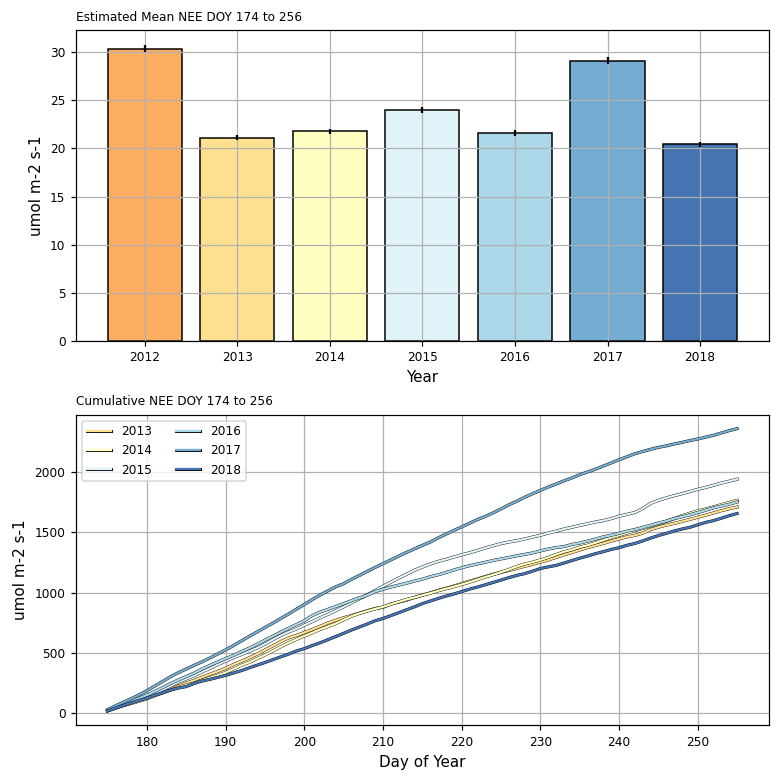

In [39]:
#normalize item number values to colormap
norm = mpl.colors.Normalize(vmin=0, vmax=10)
Colors = []
for i in range(0,10):
    rgba_color = cm.RdYlBu(norm(i)) 
    print(rgba_color)
    Colors.append(rgba_color)
    
Colors = Colors[4]
Temp = All.loc[All['Flux']=='NME']
print(Colors)

cm_2_in=1/2.54 
fig,ax=plt.subplots(2,figsize=(18.2*cm_2_in, 18.2*cm_2_in))
ax[0].bar(Temp['Year'],Temp['Estimates'],yerr=Temp['95% CI/PI'],color=Colors,edgecolor='k')

for y in T30.index.year.unique():
    if y >2012 and y<2019:
        i = y-2012
        Year = T30.loc[((T30.index.year==y)&
                        (T30['DOY']>174)&(T30['DOY']<256))].resample('D').mean()
        ax[1].plot(Year.DOY,Year['NME_est'].cumsum(),color=Colors[i],path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()],label = str(y))
#         print(Year.index)
        
        
ax[0].set_title('Estimated Mean NME DOY 174 to 256',loc='left')
ax[0].set_ylabel('umol m-2 s-1')
ax[0].grid()
ax[0].set_xlabel('Year')
# ax[0].set_facecolor([.8,.8,.8])
ax[1].set_title('Cumulative NME DOY 174 to 256',loc='left')
ax[1].set_ylabel('umol m-2 s-1')
ax[1].grid()
ax[1].set_xlabel('Day of Year')
ax[1].legend(ncol=2)
# ax[1].set_facecolor([.8,.8,.8])


plt.tight_layout()

plt.savefig('C:\\Users\\wesle\\Google Drive\\PhD_Thesis\\Chapter3_Figs/NME_Estimates.png')

(0.6470588235294118, 0.0, 0.14901960784313725, 1.0)
(0.8392925797770088, 0.18454440599769317, 0.1528642829680892, 1.0)
(0.9568627450980393, 0.42745098039215684, 0.2627450980392157, 1.0)
(0.9914648212226067, 0.677354863514033, 0.37808535178777386, 1.0)
(0.996078431372549, 0.8784313725490196, 0.5647058823529412, 1.0)
(0.9976163014225298, 0.9990772779700116, 0.7534025374855825, 1.0)
(0.8784313725490197, 0.9529411764705882, 0.9725490196078429, 1.0)
(0.6663590926566707, 0.8475970780469052, 0.9118800461361016, 1.0)
(0.4549019607843137, 0.6784313725490196, 0.8196078431372549, 1.0)
(0.26905036524413684, 0.4539792387543252, 0.7034986543637063, 1.0)


<IPython.core.display.Javascript object>


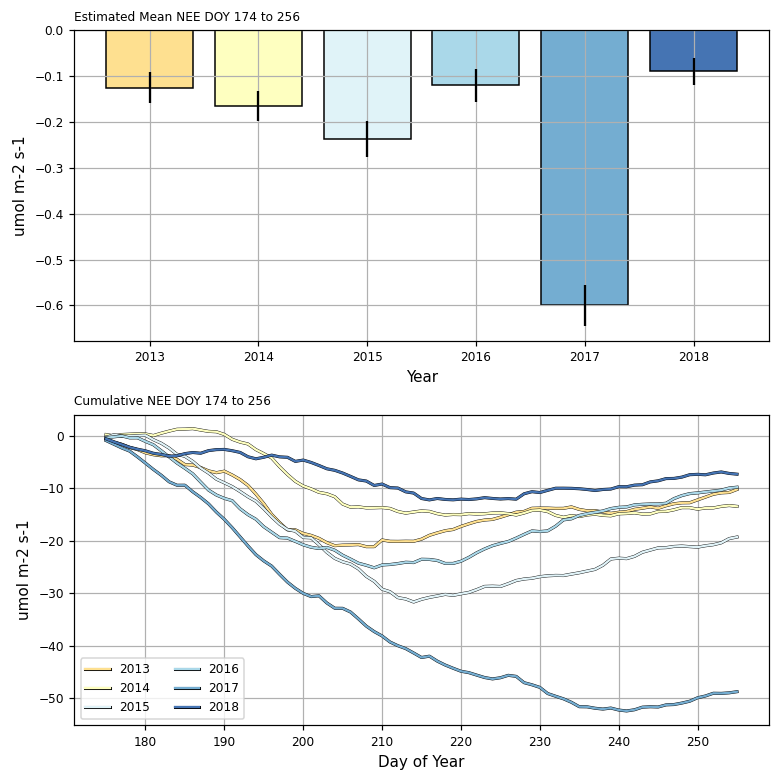

In [41]:


#normalize item number values to colormap
norm = mpl.colors.Normalize(vmin=0, vmax=10)
Colors = []
for i in range(0,10):
    rgba_color = cm.RdYlBu(norm(i)) 
    print(rgba_color)
    Colors.append(rgba_color)
    
Temp = All.loc[All['Flux']=='NEE'][4:]


cm_2_in=1/2.54 
fig,ax=plt.subplots(2,figsize=(18.2*cm_2_in, 18.2*cm_2_in))

# Yearly = T30.loc[((T30.index.year==y)&
#                         (T30['DOY']>174)&(T30['DOY']<256))].resample('Y').mean()
# Yearlys = T30.loc[((T30.index.year==y)&
#                         (T30['DOY']>174)&(T30['DOY']<256))].resample('Y').std()

# ax[0].bar(Yearly.inex,Yearly['NEE_est'],yerr=Temp['95% CI/PI']*CO2,color=Colors,edgecolor='k')

ax[0].bar(Temp['Year'],Temp['Estimates'],yerr=Temp['95% CI/PI'],color=Colors[4:],edgecolor='k')

for y in T30.index.year.unique():
    if y >2012 and y<2019:
        i = y-2009
        Year = T30.loc[((T30.index.year==y)&
                        (T30['DOY']>174)&(T30['DOY']<256))].resample('D').mean()
        ax[1].plot(Year.DOY,Year['NEE_est'].cumsum(),color=Colors[i],path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()],label = str(y))
#         print(Year.index)
        
        
ax[0].set_title('Estimated Mean NEE DOY 174 to 256',loc='left')
ax[0].set_ylabel('umol m-2 s-1')
ax[0].grid()
ax[0].set_xlabel('Year')
# ax[0].set_facecolor([.8,.8,.8])
ax[1].set_title('Cumulative NEE DOY 174 to 256',loc='left')
ax[1].set_ylabel('umol m-2 s-1')
ax[1].grid()
ax[1].set_xlabel('Day of Year')
ax[1].legend(ncol=2)
# ax[1].set_facecolor([.8,.8,.8])


plt.tight_layout()

plt.savefig('C:\\Users\\wesle\\Google Drive\\PhD_Thesis\\Chapter3_Figs/NEE_Estimates.png')